## Simple example of TuRBO-m

In [2]:
import sys
sys.path.append('/home/aditya/Documents/TuRBO-master')

from turbo.turbo_m import TurboM

import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

## Set up an optimization problem class

In [3]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        self.query_count = 0  # Initialize query counter
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        # Increment the query counter
        self.query_count += 1
        
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val


f = Levy(10)

## Create a Turbo optimizer instance

In [4]:
turbo_m = TurboM(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=1000,  # Maximum number of evaluations
    n_trust_regions=5,  # Number of trust regions
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


# Run the optimization process

In [5]:
turbo_m.optimize()

TR-0 starting from: 19.05
TR-1 starting from: 20.6
TR-2 starting from: 18.45
TR-3 starting from: 30.46
TR-4 starting from: 25.05
50) New best @ TR-1: 11.28
90) New best @ TR-1: 4.604
100) New best @ TR-1: 3.82
130) New best @ TR-1: 2.813
140) New best @ TR-1: 2.355
260) New best @ TR-2: 2.127
380) New best @ TR-4: 1.829
410) New best @ TR-4: 1.135
430) New best @ TR-4: 1.013
480) New best @ TR-2: 0.845
520) New best @ TR-2: 0.7834
520) New best @ TR-4: 0.6059
540) New best @ TR-4: 0.3736
580) New best @ TR-4: 0.3658
610) New best @ TR-4: 0.3083
690) New best @ TR-4: 0.2026
710) New best @ TR-4: 0.1596
740) New best @ TR-4: 0.1262
760) New best @ TR-4: 0.113
770) New best @ TR-4: 0.1087
780) New best @ TR-4: 0.08681
810) New best @ TR-4: 0.06073
830) New best @ TR-4: 0.05249
860) New best @ TR-4: 0.04526
870) New best @ TR-4: 0.03796
880) New best @ TR-4: 0.03265
920) New best @ TR-4: 0.02049
930) New best @ TR-4: 0.0157
940) New best @ TR-4: 0.01134
990) TR-4 converged to: : 0.01134
99

In [6]:
# After optimization process
print("Total number of queries to the black box function:", f.query_count)

Total number of queries to the black box function: 1000


## Extract all evaluations from Turbo and print the best

In [7]:
X = turbo_m.X  # Evaluated points
fX = turbo_m.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 0.011
Observed at:
	x = [1.046 0.973 0.986 0.937 0.975 0.986 0.909 0.981 1.067 0.886]


/tmp/ipykernel_8147/3857413194.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))


## Plot the progress

TuRBO-5 converges to a solution close to the global optimum

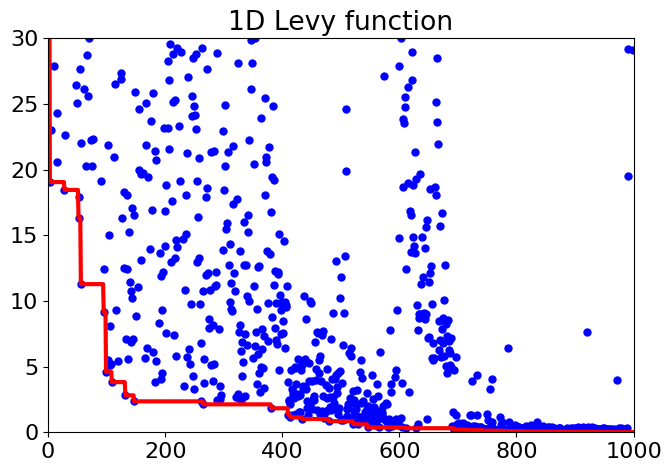

In [18]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.title("1D Levy function")

plt.tight_layout()
plt.show()

### This plot highlights how quickly the algorithm converges to the optimal solution.

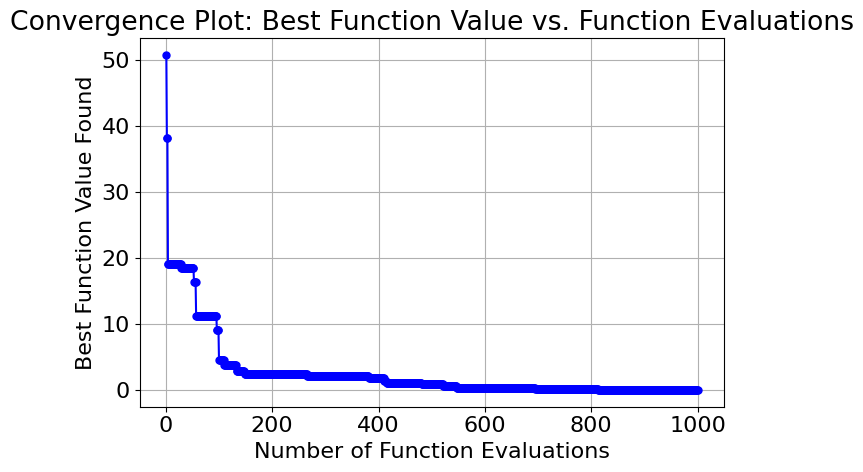

In [9]:
# Extract the best function values and cumulative minimum
best_values = np.minimum.accumulate(fX)

# Plot the best function value found versus the number of function evaluations
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, len(best_values) + 1), best_values, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Best Function Value Found')
plt.title('Convergence Plot: Best Function Value vs. Function Evaluations')
plt.grid(True)
plt.tight_layout()
plt.show()

# Ackley Function

In [10]:
class Ackley:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -32.768 * np.ones(dim)
        self.ub = 32.768 * np.ones(dim)
        self.query_count = 0  # Initialize query counter
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        # Increment the query counter
        self.query_count += 1
        
        a = 20
        b = 0.2
        c = 2 * np.pi
        
        term1 = -a * np.exp(-b * np.sqrt((1 / self.dim) * np.sum(x**2)))
        term2 = -np.exp((1 / self.dim) * np.sum(np.cos(c * x)))
        
        val = term1 + term2 + a + np.exp(1)
        return val


In [11]:

f_ackley = Ackley(dim=10)

In [12]:

# Now let's optimize using TurboM
turbo_m_ackley = TurboM(
    f=f_ackley,  # Handle to objective function
    lb=f_ackley.lb,  # Numpy array specifying lower bounds
    ub=f_ackley.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=1000,  # Maximum number of evaluations
    n_trust_regions=5,  # Number of trust regions
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

turbo_m_ackley.optimize()


Using dtype = torch.float64 
Using device = cpu
TR-0 starting from: 20.56
TR-1 starting from: 20.9
TR-2 starting from: 20.82
TR-3 starting from: 20.48
TR-4 starting from: 20.83
60) New best @ TR-3: 19.52
80) New best @ TR-3: 18.76
90) New best @ TR-3: 16.86
100) New best @ TR-3: 15.9
120) New best @ TR-3: 12.07
140) New best @ TR-3: 9.214
150) New best @ TR-3: 8.113
160) New best @ TR-3: 7.384
190) New best @ TR-3: 5.87
200) New best @ TR-3: 4.716
210) New best @ TR-3: 4.498
240) New best @ TR-3: 3.418
260) New best @ TR-3: 3.246
270) New best @ TR-3: 2.651
290) New best @ TR-3: 2.383
300) New best @ TR-3: 2.371
310) New best @ TR-3: 2.178
330) New best @ TR-3: 1.253
350) TR-3 converged to: : 1.253
350) TR-3 is restarting from: : 16.33
620) TR-3 converged to: : 1.761
620) TR-3 is restarting from: : 20.31
900) TR-3 converged to: : 1.913
900) TR-3 is restarting from: : 19.05


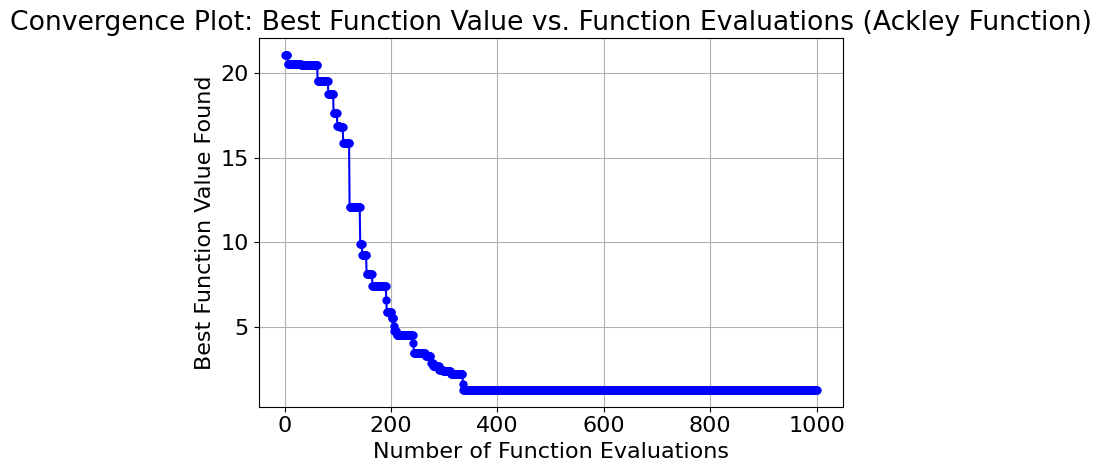

In [13]:

# Extract the best function values and cumulative minimum
best_values_ackley = np.minimum.accumulate(turbo_m_ackley.fX)

# Plot the best function value found versus the number of function evaluations
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, len(best_values_ackley) + 1), best_values_ackley, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Best Function Value Found')
plt.title('Convergence Plot: Best Function Value vs. Function Evaluations (Ackley Function)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:

# After optimization process
print("Total number of queries to the black box function (Ackley):", f_ackley.query_count)

X_ackley = turbo_m_ackley.X  # Evaluated points
fX_ackley = turbo_m_ackley.fX  # Observed values
ind_best_ackley = np.argmin(fX_ackley)
f_best_ackley, x_best_ackley = fX_ackley[ind_best_ackley], X_ackley[ind_best_ackley, :]

print("Best value found (Ackley):\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 3)))


Total number of queries to the black box function (Ackley): 1000
Best value found (Ackley):
	f(x) = 1.253
Observed at:
	x = [-0.072  0.079 -0.261  0.142 -0.023  0.103  0.139  0.057 -0.197  0.081]


/tmp/ipykernel_8147/3432223255.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found (Ackley):\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 3)))


#### To compare the changes while increasing the number of trust regions `m`, we can run the optimization process for different values of m and observe how the convergence behavior differs. 

In [15]:
def optimize_ackley(num_trust_regions):
    turbo_m_ackley = TurboM(
        f=f_ackley,  # Handle to objective function
        lb=f_ackley.lb,  # Numpy array specifying lower bounds
        ub=f_ackley.ub,  # Numpy array specifying upper bounds
        n_init=10,  # Number of initial bounds from an Symmetric Latin hypercube design
        max_evals=1000,  # Maximum number of evaluations
        n_trust_regions=num_trust_regions,  # Number of trust regions
        batch_size=10,  # How large batch size TuRBO uses
        verbose=True,  # Print information from each batch
        use_ard=True,  # Set to true if you want to use ARD for the GP kernel
        max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
        n_training_steps=50,  # Number of steps of ADAM to learn the hypers
        min_cuda=1024,  # Run on the CPU for small datasets
        device="cpu",  # "cpu" or "cuda"
        dtype="float64",  # float64 or float32
    )

    turbo_m_ackley.optimize()
    return turbo_m_ackley

# Create Ackley function instance
f_ackley = Ackley(dim=10)

# Number of trust regions to test
num_trust_regions_list = [2, 3, 5, 7, 10]

# Run optimization for different numbers of trust regions
optimized_results = []
for num_trust_regions in num_trust_regions_list:
    optimized_results.append(optimize_ackley(num_trust_regions))

Using dtype = torch.float64 
Using device = cpu
TR-0 starting from: 19.1
TR-1 starting from: 19.88
40) New best @ TR-0: 18.94
50) New best @ TR-0: 16.84
60) New best @ TR-0: 16.58
70) New best @ TR-0: 14.95
80) New best @ TR-0: 10.73
100) New best @ TR-0: 10.24
110) New best @ TR-0: 9.029
130) New best @ TR-0: 6.024
150) New best @ TR-0: 4.656
160) New best @ TR-0: 3.84
170) New best @ TR-0: 3.683
190) New best @ TR-0: 3.276
210) New best @ TR-0: 2.708
220) New best @ TR-0: 2.687
230) New best @ TR-0: 1.196
270) TR-0 converged to: : 1.196
270) TR-0 is restarting from: : 20.6
550) TR-1 converged to: : 2.707
550) TR-1 is restarting from: : 20.74
910) TR-0 converged to: : 1.668
910) TR-0 is restarting from: : 20.49
Using dtype = torch.float64 
Using device = cpu
TR-0 starting from: 20.53
TR-1 starting from: 19.83
TR-2 starting from: 20.69
40) New best @ TR-1: 19.0
50) New best @ TR-1: 17.0
60) New best @ TR-1: 14.06
90) New best @ TR-1: 9.426
100) New best @ TR-1: 8.322
110) New best @ TR

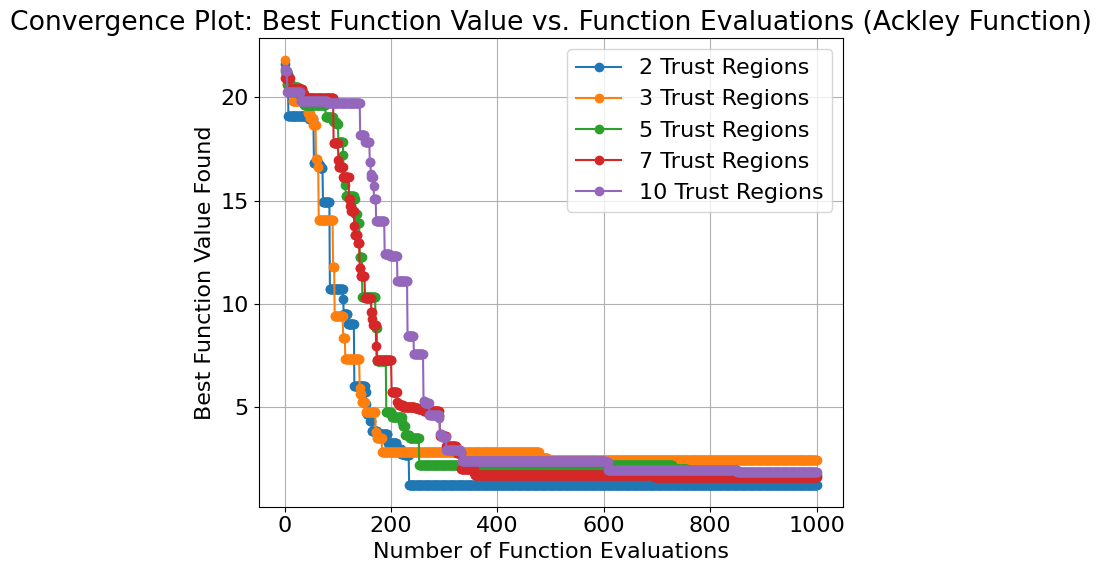

Total number of queries to the black box function (Ackley) with 2 trust regions: 5000
Best value found (Ackley) with 2 trust regions:
	f(x) = 1.196
Observed at:
	x = [ 0.19 -0.05  0.17 -0.19 -0.02 -0.14 -0.2   0.01 -0.03  0.03]
Total number of queries to the black box function (Ackley) with 3 trust regions: 5000
Best value found (Ackley) with 3 trust regions:
	f(x) = 2.414
Observed at:
	x = [ 0.06  0.3  -0.7  -0.07  0.16 -0.06 -0.16 -0.18  0.38  0.15]
Total number of queries to the black box function (Ackley) with 5 trust regions: 5000
Best value found (Ackley) with 5 trust regions:
	f(x) = 1.691
Observed at:
	x = [-0.18  0.05 -0.2   0.17 -0.32 -0.1   0.    0.02  0.13 -0.24]
Total number of queries to the black box function (Ackley) with 7 trust regions: 5000
Best value found (Ackley) with 7 trust regions:
	f(x) = 1.616
Observed at:
	x = [-0.02 -0.22 -0.05  0.1  -0.08 -0.09 -0.39 -0.15 -0.06 -0.2 ]
Total number of queries to the black box function (Ackley) with 10 trust regions: 5000
B

/tmp/ipykernel_8147/299707352.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best value found (Ackley) with {num_trust_regions_list[i]} trust regions:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 2)))


In [21]:

# Plot the convergence plots for different numbers of trust regions
plt.figure(figsize=(7, 6))
for i, turbo_m in enumerate(optimized_results):
    best_values = np.minimum.accumulate(turbo_m.fX)
    plt.plot(np.arange(1, len(best_values) + 1), best_values, marker='o', label=f"{num_trust_regions_list[i]} Trust Regions")

plt.xlabel('Number of Function Evaluations')
plt.ylabel('Best Function Value Found')
plt.title('Convergence Plot: Best Function Value vs. Function Evaluations (Ackley Function)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# After optimization process
for i, turbo_m in enumerate(optimized_results):
    print(f"Total number of queries to the black box function (Ackley) with {num_trust_regions_list[i]} trust regions:", f_ackley.query_count)

    X_ackley = turbo_m.X  # Evaluated points
    fX_ackley = turbo_m.fX  # Observed values
    ind_best_ackley = np.argmin(fX_ackley)
    f_best_ackley, x_best_ackley = fX_ackley[ind_best_ackley], X_ackley[ind_best_ackley, :]

    print(f"Best value found (Ackley) with {num_trust_regions_list[i]} trust regions:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 2)))


### Increasing Number of Dimensions

In [17]:
class Ackley_m:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -32.768 * np.ones(dim)
        self.ub = 32.768 * np.ones(dim)
        self.query_count = 0  # Initialize query counter
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        # Increment the query counter
        self.query_count += 1
        
        a = 20
        b = 0.2
        c = 2 * np.pi
        
        term1 = -a * np.exp(-b * np.sqrt((1 / self.dim) * np.sum(x**2)))
        term2 = -np.exp((1 / self.dim) * np.sum(np.cos(c * x)))
        
        val = term1 + term2 + a + np.exp(1)
        return val

In [22]:

def optimize_ackley_m(dim):
    f_ackley = Ackley_m(dim=dim)
    
    turbo_m_ackley_m = TurboM(
        f=f_ackley,  # Handle to objective function
        lb=f_ackley.lb,  # Numpy array specifying lower bounds
        ub=f_ackley.ub,  # Numpy array specifying upper bounds
        n_init=10,  # Number of initial bounds from a Symmetric Latin hypercube design
        max_evals=1000,  # Maximum number of evaluations
        n_trust_regions=4,  # Number of trust regions
        batch_size=10,  # How large batch size TuRBO uses
        verbose=True,  # Print information from each batch
        use_ard=True,  # Set to true if you want to use ARD for the GP kernel
        max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
        n_training_steps=50,  # Number of steps of ADAM to learn the hypers
        min_cuda=1024,  # Run on the CPU for small datasets
        device="cpu",  # "cpu" or "cuda"
        dtype="float64",  # float64 or float32
    )

    turbo_m_ackley_m.optimize()
    return turbo_m_ackley_m

In [23]:

# Dimensionalities of the Ackley function to test
dims = [2, 5, 10, 20, 50]

# Run optimization for different dimensionalities
optimized_results = []
for dim in dims:
    optimized_results.append(optimize_ackley_m(dim))

Using dtype = torch.float64 
Using device = cpu
TR-0 starting from: 13.83
TR-1 starting from: 18.26
TR-2 starting from: 16.38
TR-3 starting from: 13.47
40) New best @ TR-0: 6.669
40) New best @ TR-2: 10.47
40) New best @ TR-3: 8.221
50) New best @ TR-3: 3.135
70) New best @ TR-2: 2.821
100) New best @ TR-3: 2.68
110) New best @ TR-3: 1.695
120) New best @ TR-0: 1.432
130) New best @ TR-3: 0.8237
160) New best @ TR-3: 0.4153
190) TR-3 converged to: : 0.4153
190) TR-3 is restarting from: : 11.6
230) New best @ TR-0: 0.1686
270) TR-0 converged to: : 0.1686
270) TR-0 is restarting from: : 11.16
320) New best @ TR-2: 0.1202
340) TR-2 converged to: : 0.1202
340) TR-2 is restarting from: : 18.64
480) TR-3 converged to: : 0.2882
480) TR-3 is restarting from: : 14.86
590) TR-0 converged to: : 0.1901
590) TR-0 is restarting from: : 11.86
740) New best @ TR-0: 0.112
760) TR-0 converged to: : 0.112
760) TR-0 is restarting from: : 19.6
910) New best @ TR-3: 0.09765
930) TR-3 converged to: : 0.09765

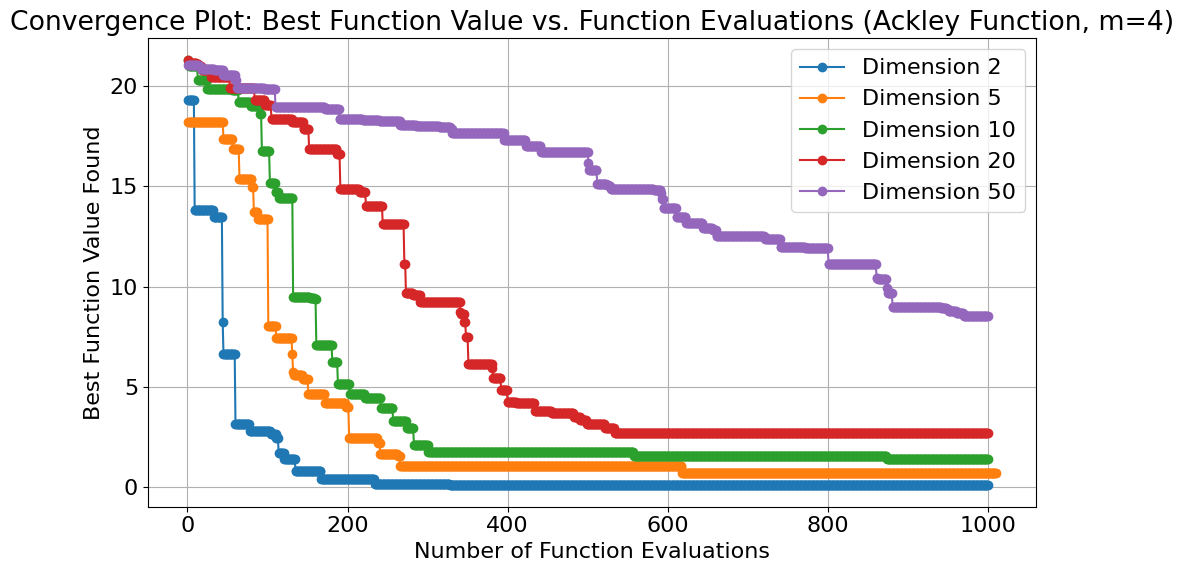

Total number of queries to the black box function (Ackley, Dimension 2): 1000
Best value found (Ackley, Dimension 2):
	f(x) = 0.098
Observed at:
	x = [ 0.022 -0.016]
Total number of queries to the black box function (Ackley, Dimension 5): 1010
Best value found (Ackley, Dimension 5):
	f(x) = 0.724
Observed at:
	x = [-0.104  0.07  -0.071 -0.059  0.121]
Total number of queries to the black box function (Ackley, Dimension 10): 1000
Best value found (Ackley, Dimension 10):
	f(x) = 1.417
Observed at:
	x = [-0.286  0.037 -0.069 -0.142  0.241 -0.026  0.038  0.04  -0.005  0.233]
Total number of queries to the black box function (Ackley, Dimension 20): 1000
Best value found (Ackley, Dimension 20):
	f(x) = 2.734
Observed at:
	x = [ 0.556 -0.08   0.135  0.201  0.063 -0.161  0.146  0.866  0.186  0.733
  0.22  -0.074 -0.276  0.074 -0.145  0.271  0.239 -0.658  0.028  0.322]
Total number of queries to the black box function (Ackley, Dimension 50): 1000
Best value found (Ackley, Dimension 50):
	f(x) = 

/tmp/ipykernel_8147/3167195415.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best value found (Ackley, Dimension {dims[i]}):\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 3)))


In [24]:

# Plot the convergence plots for different dimensionalities
plt.figure(figsize=(10, 6))
for i, turbo_m in enumerate(optimized_results):
    best_values = np.minimum.accumulate(turbo_m.fX)
    plt.plot(np.arange(1, len(best_values) + 1), best_values, marker='o', label=f"Dimension {dims[i]}")

plt.xlabel('Number of Function Evaluations')
plt.ylabel('Best Function Value Found')
plt.title('Convergence Plot: Best Function Value vs. Function Evaluations (Ackley Function, m=4)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# After optimization process
for i, turbo_m in enumerate(optimized_results):
    print(f"Total number of queries to the black box function (Ackley, Dimension {dims[i]}):", turbo_m.f.query_count)

    X_ackley = turbo_m.X  # Evaluated points
    fX_ackley = turbo_m.fX  # Observed values
    ind_best_ackley = np.argmin(fX_ackley)
    f_best_ackley, x_best_ackley = fX_ackley[ind_best_ackley], X_ackley[ind_best_ackley, :]

    print(f"Best value found (Ackley, Dimension {dims[i]}):\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best_ackley, np.around(x_best_ackley, 3)))
